In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tqdm.notebook import tqdm
from time import time
from collections import defaultdict
from IPython.display import clear_output

import nltk

from umap import UMAP
from sklearn.decomposition import PCA

sns.set(font_scale=1.3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data

In [2]:
data = pd.read_csv('emotions_short.csv', index_col='Unnamed: 0')
data.head()

,Text,Emotion
0,im grabbing a minute to post i feel greedy wrong,anger
1,i am feeling grouchy,anger
2,i think it s the easiest time of year to feel ...,anger
3,i feel irritated and rejected without anyone d...,anger
4,i already feel like i fucked up though because...,anger


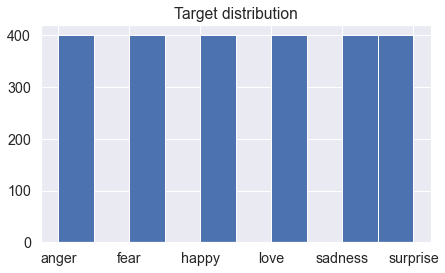

In [42]:
plt.figure(figsize=(7, 4))
plt.title('Target distribution')
plt.hist(data['Emotion']);

# Structured-Self-Attentive-Sentence-Embedding

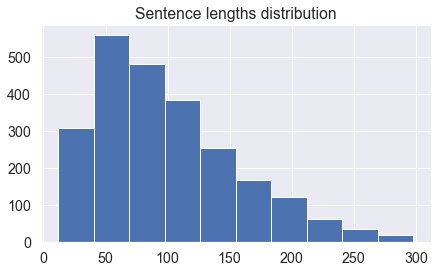

In [3]:
lens = []
for sentence in data['Text']:
    lens.append(len(sentence))

plt.figure(figsize=(7, 4))
plt.title('Sentence lengths distribution')
plt.hist(lens);

In [4]:
max_len = 150

In [9]:
pad_symbol = '<pad>'


def get_embedding_weights():
    embeddings_dict = {}
    with open("glove.6B.100d.txt", 'r', encoding='utf8') as f:
        for line in tqdm(f):
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
            
    sentence_tokens = [nltk.word_tokenize(sentence) for sentence in data['Text']]

    dictionary = {word for tokens in sentence_tokens for word in tokens}
    dictionary.add(pad_symbol)
    word2idx = {word: index for index, word in enumerate(dictionary)}
    
    matrix_len = len(dictionary)
    weights_matrix = np.zeros((matrix_len, 100))
    
    words_found = 0
    for word, index in tqdm(word2idx.items()):
        try: 
            weights_matrix[index] = embeddings_dict[word]
            words_found += 1
        except KeyError:
            weights_matrix[index] = np.random.uniform(size=100)
            
    return weights_matrix, word2idx

In [6]:
embedding_weights, word2idx = get_embedding_weights()

0it [00:00, ?it/s]

  0%|          | 0/5562 [00:00<?, ?it/s]

In [10]:
def sentences_to_idx(word2idx):
    sentence_tokens = [nltk.word_tokenize(sentence) for sentence in data['Text']]
    for i, sentence_token in enumerate(sentence_tokens):
        tokens_to_add = max(0, max_len - len(sentence_token))
        sentence_tokens[i] += ([pad_symbol] * tokens_to_add)[:max_len]
        
    return np.array([[word2idx[word] for word in sentence] for sentence in sentence_tokens])

In [11]:
label_encoder = LabelEncoder().fit(data['Emotion'])

X = sentences_to_idx(word2idx)
y = label_encoder.transform(data['Emotion'])

In [12]:
class EmotionsDataset(Dataset):
    def __init__(self, sentences, target):
        
        self.sentences = sentences
        self.target = target
        
    def __getitem__(self, idx):
        return torch.tensor(self.sentences[idx]).long(), torch.tensor(self.target[idx]).long()
    
    def __len__(self):
        return len(self.target)

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

train_dataset = EmotionsDataset(X_train, y_train)
val_dataset = EmotionsDataset(X_val, y_val)

In [27]:
class WordEmbedding(nn.Module):
    def __init__(self, vocab_size, embd_size, pre_embd=None, is_train_embd=False):
        super(WordEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embd_size)
        if pre_embd is not None:
            self.embedding.weight = nn.Parameter(torch.from_numpy(pre_embd), requires_grad=is_train_embd)

    def forward(self, x):
        return F.relu(self.embedding(x))


class SelfAttentiveNet(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size=300, mlp_hidden=350, r=30, pre_embd=None, is_train_embd=True):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, emb_size)
        if pre_embd is not None:
            self.embedding.weight = nn.Parameter(torch.from_numpy(pre_embd), requires_grad=is_train_embd)
        
        initrange = 0.1
        self.encoder = nn.LSTM(emb_size, hidden_size, batch_first=True, bidirectional=True)
        self.Ws1 = nn.Parameter(torch.Tensor(1, mlp_hidden, 2*hidden_size).uniform_(-initrange, initrange))
        self.Ws2 = nn.Parameter(torch.Tensor(1, r, mlp_hidden).uniform_(-initrange, initrange))
        
        self.dropout = nn.Dropout(0.5)
        
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        bs = x.size(0)
        n  = x.size(1)
        
        x = self.embedding(x).float()
        H, _ = self.encoder(x)
        H_T = H.permute(0, 2, 1).contiguous()
        H_T = self.dropout(H_T)
        
        A = self.tanh(torch.bmm(self.Ws1.repeat(bs, 1, 1), H_T))
        A = torch.bmm(self.Ws2.repeat(bs, 1, 1), A)
        A = self.softmax(A.view(-1, n)).view(bs, -1, n)

        M = torch.bmm(A, H)
        
        return M.mean(axis=1)
    
    def encode(self, sentence):
        sentence_tokens = nltk.word_tokenize(sentence)
        x = torch.tensor([word2idx[word] for word in sentence_tokens]).long().unsqueeze(0).to(device)
        return self.forward(x).squeeze(0).detach().cpu().numpy()
    

class SelfAttentiveClassifierNet(nn.Module):
    def __init__(
        self, 
        vocab_size, 
        emb_size, 
        num_classes, 
        hidden_size=300, 
        mlp_hidden=350, 
        r=30, 
        pre_embd=None, 
        is_train_embd=True
    ):
        super().__init__()
        
        self.sentence_emb = SelfAttentiveNet(vocab_size, emb_size, hidden_size, mlp_hidden, r, pre_embd, is_train_embd)
        self.dropout_1 = nn.Dropout(0.5)
        self.linear_1 = nn.Linear(2 * hidden_size, 2000)
        self.relu = nn.ReLU()
        self.dropout_2 = nn.Dropout(0.5)
        self.linear_2 = nn.Linear(2000, num_classes)
        
    def forward(self, x):
        bs = x.size(0)
        
        x = self.sentence_emb(x)
        x = self.linear_1(self.dropout_1(x))
        x = self.relu(x)
        x = self.linear_2(self.dropout_2(x))
        return x

In [15]:
def plot_history(history, num_epochs):
    plt.figure(figsize=(16, 7))
    
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(num_epochs) + 1, history['train_loss'], label='train loss')
    plt.plot(np.arange(num_epochs) + 1, history['val_loss'], label='validation loss')
    plt.xlabel('num epochs')
    plt.ylabel('accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(np.arange(num_epochs) + 1, history['train_acc'], label='train accuracy')
    plt.plot(np.arange(num_epochs) + 1, history['val_acc'], label='validation accuracy')
    plt.xlabel('num epochs')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

    
def train(
    model, 
    criterion, 
    optimizer, 
    train_data, 
    val_data, 
    num_epochs,
    model_path_to_save,
    history_path_to_save
):
    history = defaultdict(list)
    best_score = 0
    
    for epoch in range(num_epochs):
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        
        start_time = time()
        model.train(True)
        for X_train_batch, y_train_batch in tqdm(train_data):
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            
            predictions = model(X_train_batch)
            loss = criterion(predictions, y_train_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.cpu().item()
            
            target = y_train_batch.detach().cpu().numpy()
            predictions = predictions.detach().cpu().numpy().argmax(axis=1)

            train_acc += (target == predictions).mean()
            
        train_loss /= len(train_data)
        train_acc /= len(train_data)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        with torch.no_grad():
            model.train(False)
            for X_val_batch, y_val_batch in tqdm(val_data):
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

                predictions = model(X_val_batch)
                loss = criterion(predictions, y_val_batch)

                val_loss += loss.cpu().item()
            
                target = y_val_batch.detach().cpu().numpy()
                predictions = predictions.detach().cpu().numpy().argmax(axis=1)

                val_acc += (target == predictions).mean()

            val_loss /= len(val_data)
            val_acc /= len(val_data)

            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)
            
            if best_score < val_acc:
                torch.save(model.state_dict(), model_path_to_save)
                pd.DataFrame(history).to_csv(history_path_to_save, index=False)
                best_score = val_acc
                
        clear_output()
        plot_history(history, epoch + 1)
        print('epoch number: {}'.format(epoch + 1))
        print('time per epoch: {}s'.format(np.round(time() - start_time, 3)))
        print('validation acc: {}'.format(np.round(history['val_acc'][-1], 3) * 100))
        print('validation loss: {}'.format(np.round(history['val_loss'][-1], 3)))
    return model, history

In [16]:
import gc
gc.collect()

3344

In [17]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

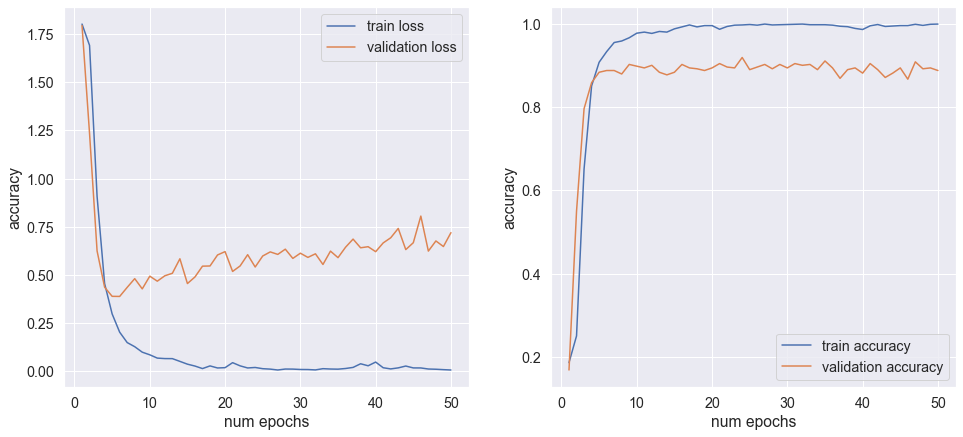

epoch number: 50
time per epoch: 2.565s
validation acc: 88.8
validation loss: 0.719


In [18]:
vocab_size, emb_size = embedding_weights.shape

model = SelfAttentiveClassifierNet(vocab_size, emb_size, 6, pre_embd=embedding_weights).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

model, history = train(
    model, criterion, optimizer,
    train_dataloader, val_dataloader, num_epochs=50,
    model_path_to_save='./weights/self_attentive_mean_drop_3.pht',
    history_path_to_save='./histories/self_attentive_mean_drop_3.csv'
)

In [19]:
# modules = [module for module in model.modules()]
# torch.save(modules[1].state_dict(), './weights/self_attentive_emb.pth')

In [28]:
model = SelfAttentiveNet(vocab_size, emb_size, pre_embd=embedding_weights).to(device)
model.load_state_dict(torch.load('./weights/self_attentive_emb.pth'))

<All keys matched successfully>

In [35]:
sentence_embeddings = []

for sentence in tqdm(data['Text']):
    sentence_embeddings.append(model.encode(sentence))
    
sentence_embeddings = np.array(sentence_embeddings)

  0%|          | 0/2400 [00:00<?, ?it/s]

In [41]:
columns = ['emb_dim_{}'.format(i + 1) for i in range(600)]

pd.DataFrame(sentence_embeddings, columns=columns).to_csv('./embeddings/self_attentive_embeddings.csv', index=False)

In [48]:
pca = PCA(n_components=20).fit(sentence_embeddings)
transformed_embeddings = pca.transform(sentence_embeddings)

In [49]:
umap_emb = UMAP().fit_transform(transformed_embeddings)

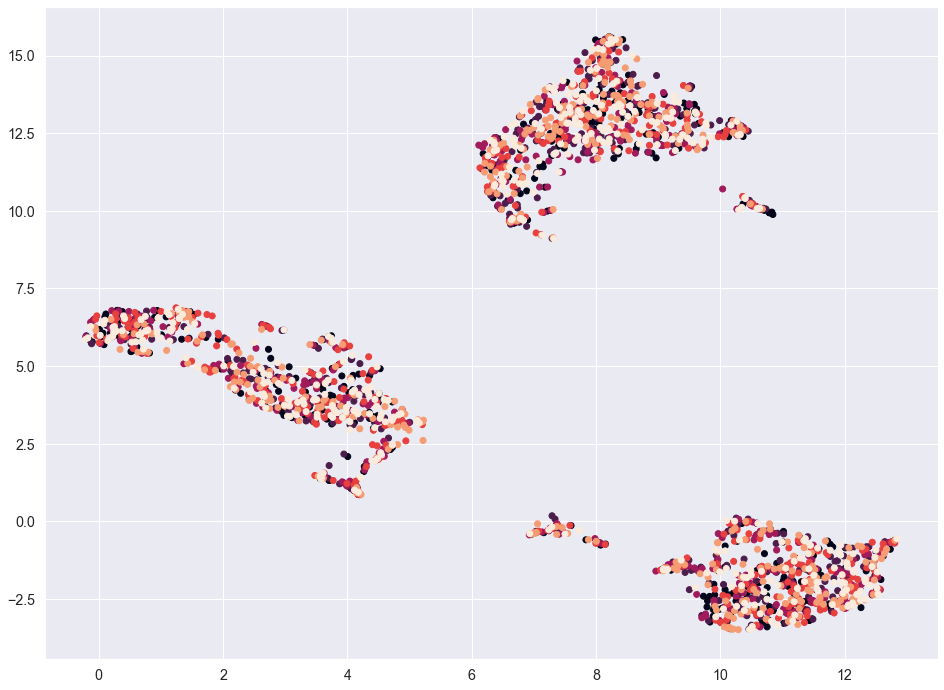

In [51]:
plt.figure(figsize=(16, 12))
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], c=y);

# Bag-Of-Words

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

In [73]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['Text'])
X.shape

(2400, 5541)

In [74]:
pca = PCA(n_components=X.shape[0]).fit(X.toarray())

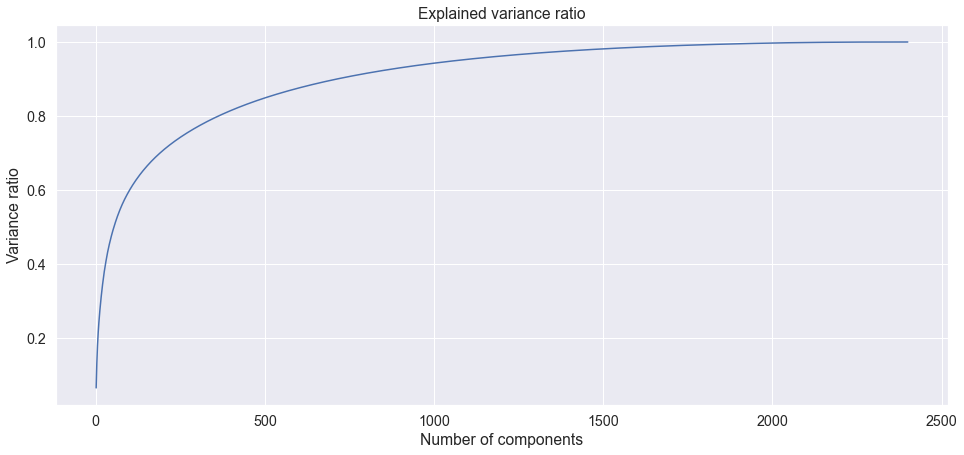

In [75]:
plt.figure(figsize=(16, 7))
plt.title('Explained variance ratio')
plt.plot(np.arange(X.shape[0]) + 1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance ratio')
plt.show()

In [78]:
pca = PCA(n_components=700).fit(X.toarray())
transformed_embeddings = pca.transform(X.toarray())

In [79]:
columns = ['emb_dim_{}'.format(i + 1) for i in range(700)]

pd.DataFrame(transformed_embeddings, columns=columns).to_csv('./embeddings/bag_of_words_embeddings.csv', index=False)

# TF-IDF

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [58]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Text'])
X.shape

(2400, 5541)

In [62]:
pca = PCA(n_components=X.shape[0]).fit(X.toarray())

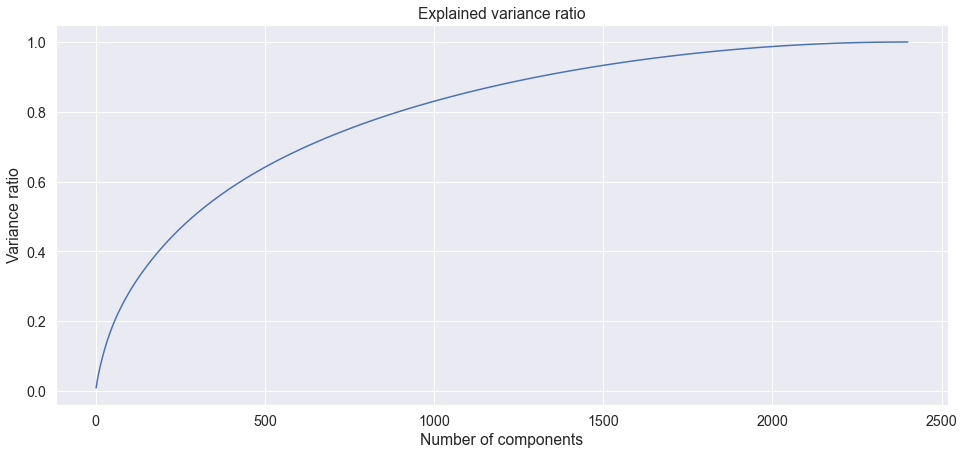

In [64]:
plt.figure(figsize=(16, 7))
plt.title('Explained variance ratio')
plt.plot(np.arange(X.shape[0]) + 1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance ratio')
plt.show()

In [69]:
pca = PCA(n_components=1400).fit(X.toarray())
transformed_embeddings = pca.transform(X.toarray())

In [72]:
columns = ['emb_dim_{}'.format(i + 1) for i in range(1400)]

pd.DataFrame(transformed_embeddings, columns=columns).to_csv('./embeddings/tf_idf_embeddings.csv', index=False)

# BERT

In [80]:
from sentence_transformers import SentenceTransformer

In [81]:
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [87]:
sentence_emb = model.encode(data['Text'])

In [94]:
columns = ['emb_dim_{}'.format(i + 1) for i in range(768)]

pd.DataFrame(sentence_emb, columns=columns).to_csv('./embeddings/bert_embeddings.csv', index=False)

# InferSent

In [98]:
from models import InferSent

In [108]:
V = 1
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent = InferSent(params_model)
infersent.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

In [103]:
W2V_PATH = 'GloVe/glove.840B.300d.txt'
infersent.set_w2v_path(W2V_PATH)

In [104]:
infersent.build_vocab(data['Text'], tokenize=True)

Found 5482(/5563) words with w2v vectors
Vocab size : 5482


In [105]:
embeddings = infersent.encode(data['Text'], tokenize=True)

C:\Users\Константин\Desktop\Twitter\models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  sentences = np.array(sentences)[idx_sort]


In [109]:
pca = PCA(n_components=embeddings.shape[0]).fit(embeddings)

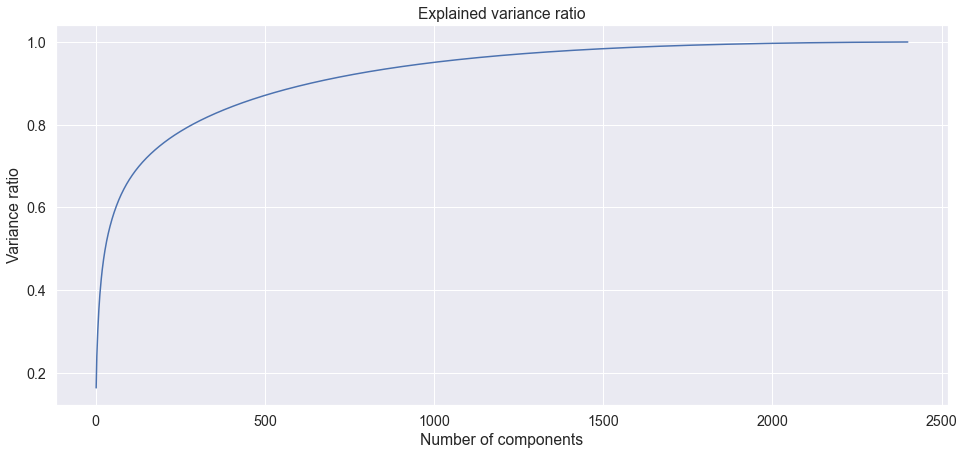

In [110]:
plt.figure(figsize=(16, 7))
plt.title('Explained variance ratio')
plt.plot(np.arange(X.shape[0]) + 1, np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Variance ratio')
plt.show()

In [136]:
pca = PCA(n_components=768).fit(embeddings)
transformed_embeddings = pca.transform(embeddings)

In [137]:
umap_emb = UMAP().fit_transform(transformed_embeddings)

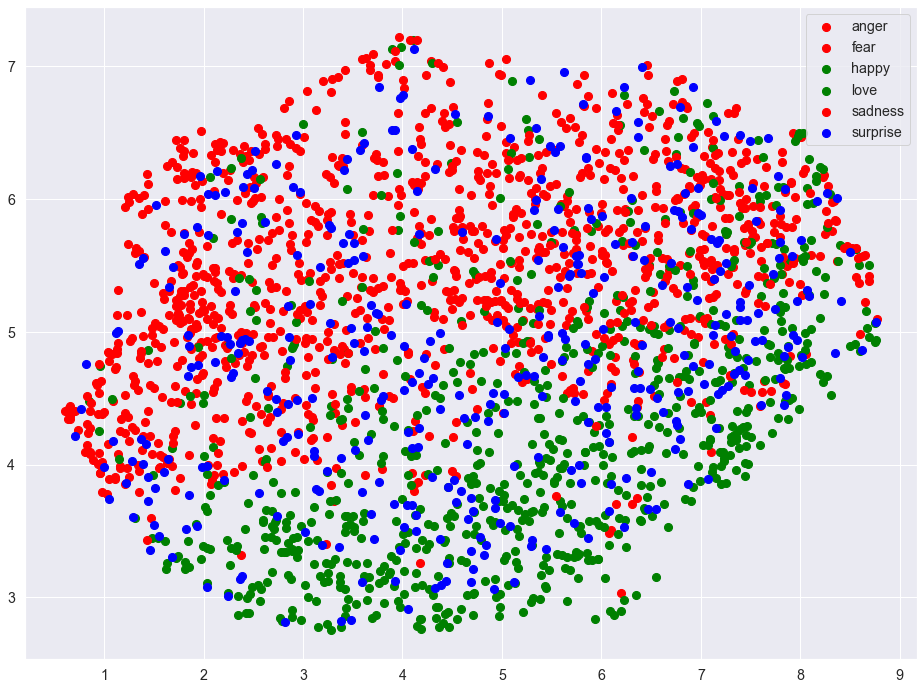

In [151]:
cdict = {0: 'red', 1: 'red', 2: 'green', 3: 'green', 4: 'red', 5: 'blue'}

plt.figure(figsize=(16, 12))
for g in np.unique(y):
    ix = np.where(y == g)
    plt.scatter(umap_emb[ix, 0], umap_emb[ix, 1], c = cdict[g], label = label_encoder.inverse_transform([g])[0], s = 65)
plt.legend()
plt.show()

In [152]:
columns = ['emb_dim_{}'.format(i + 1) for i in range(768)]

pd.DataFrame(transformed_embeddings, columns=columns).to_csv('./embeddings/infersent_embeddings.csv', index=False)